# Análisis de la Telemetría de Barcelona
Este notebook realiza un análisis de clustering sobre datos de setups recolectados el circuito de **Barcelona**.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 📍 Paso 1: Preparación de los Datos - Circuit de Barcelona Catalunya

En este paso cargamos el dataset sanetizado del circuito de Barcelona, eliminamos columnas irrelevantes (como `lapNumber` o identificadores), gestionamos valores nulos, y normalizamos los datos para su posterior análisis con técnicas de clustering.

Pasos específicos:
1. Cargar el dataset.
2. Eliminar columnas no necesarias para el clustering.
3. Filtrar vueltas inválidas (si `lapTime == 0`).
4. Normalizar las variables técnicas (`StandardScaler`).


In [2]:
import pandas as pd

# Cargar datos del circuito de Barcelona
df_barcelona = pd.read_csv("/content/drive/MyDrive/Telemetria-F1-24/barcelona_sanitized.csv")

# Vista previa de las primeras columnas
print("Columnas iniciales:", df_barcelona.columns.tolist())
df_barcelona.head()

Columnas iniciales: ['lapTimeInMS', 'm_frontWing', 'm_rearWing', 'm_onThrottle', 'm_offThrottle', 'm_frontCamber', 'm_rearCamber', 'm_frontToe', 'm_rearToe', 'm_frontSuspension', 'm_rearSuspension', 'm_frontAntiRollBar', 'm_rearAntiRollBar', 'm_frontSuspensionHeight', 'm_rearSuspensionHeight', 'm_brakePressure', 'm_brakeBias', 'm_engineBraking', 'm_rearLeftTyrePressure', 'm_rearRightTyrePressure', 'm_frontLeftTyrePressure', 'm_frontRightTyrePressure', 'm_ballast', 'm_fuelLoad', 'circuit']


,lapTimeInMS,m_frontWing,m_rearWing,m_onThrottle,m_offThrottle,m_frontCamber,m_rearCamber,m_frontToe,m_rearToe,m_frontSuspension,...,m_brakePressure,m_brakeBias,m_engineBraking,m_rearLeftTyrePressure,m_rearRightTyrePressure,m_frontLeftTyrePressure,m_frontRightTyrePressure,m_ballast,m_fuelLoad,circuit
0,73193,39,45,100,20,-3.5,-2.2,0.0,0.0,41,...,100,50,100,26.5,26.5,29.5,29.5,6,10.0,barcelona
1,73424,39,45,100,20,-3.5,-2.2,0.0,0.0,41,...,100,50,100,26.5,26.5,29.5,29.5,6,10.0,barcelona
2,73167,39,45,100,20,-3.5,-2.2,0.0,0.0,41,...,100,50,100,26.5,26.5,29.5,29.5,6,10.0,barcelona
3,73350,39,45,100,20,-3.5,-2.2,0.0,0.0,41,...,100,50,100,26.5,26.5,29.5,29.5,6,10.0,barcelona
4,73020,39,45,100,20,-3.5,-2.2,0.0,0.0,41,...,100,50,100,26.5,26.5,29.5,29.5,6,10.0,barcelona


In [3]:
# Filtrar filas con tiempo de vuelta válido
df_barcelona = df_barcelona[df_barcelona["lapTimeInMS"] > 0]

# Eliminar columnas irrelevantes
columns_to_drop = ['lapNumber', 'circuit', 'm_ballast', 'm_fuelLoad']
df_barcelona = df_barcelona.drop(columns=columns_to_drop, errors='ignore')

# Eliminar columnas completamente vacías
df_barcelona = df_barcelona.dropna(axis=1, how='all')

# Eliminar filas con valores nulos
df_barcelona = df_barcelona.dropna()

# Eliminar vueltas duplicadas (setup + tiempo idéntico)
df_barcelona = df_barcelona.drop_duplicates()

# Separar tiempos por vuelta y entradas
lap_times = df_barcelona["lapTimeInMS"]
X_raw = df_barcelona.drop(columns=["lapTimeInMS"])

print(f"Dataset limpio. Dimensiones finales: {X_raw.shape}")
X_raw.head()

Dataset limpio. Dimensiones finales: (130, 21)


,m_frontWing,m_rearWing,m_onThrottle,m_offThrottle,m_frontCamber,m_rearCamber,m_frontToe,m_rearToe,m_frontSuspension,m_rearSuspension,...,m_rearAntiRollBar,m_frontSuspensionHeight,m_rearSuspensionHeight,m_brakePressure,m_brakeBias,m_engineBraking,m_rearLeftTyrePressure,m_rearRightTyrePressure,m_frontLeftTyrePressure,m_frontRightTyrePressure
0,39,45,100,20,-3.5,-2.2,0.0,0.0,41,21,...,17,21,54,100,50,100,26.5,26.5,29.5,29.5
1,39,45,100,20,-3.5,-2.2,0.0,0.0,41,21,...,17,21,54,100,50,100,26.5,26.5,29.5,29.5
2,39,45,100,20,-3.5,-2.2,0.0,0.0,41,21,...,17,21,54,100,50,100,26.5,26.5,29.5,29.5
3,39,45,100,20,-3.5,-2.2,0.0,0.0,41,21,...,17,21,54,100,50,100,26.5,26.5,29.5,29.5
4,39,45,100,20,-3.5,-2.2,0.0,0.0,41,21,...,17,21,54,100,50,100,26.5,26.5,29.5,29.5


In [4]:
from sklearn.preprocessing import StandardScaler

# Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

print(f"Dataset limpio y normalizado. Dimensiones finales: {X_scaled.shape}")
X_scaled[:5]

Dataset limpio y normalizado. Dimensiones finales: (130, 21)


array([[-0.36523943,  1.82733817,  1.6508721 , -1.47027657, -0.49202811,
        -0.50306554, -0.72992803, -0.920345  ,  0.72388822,  2.15103595,
        -1.08004794,  1.07192648, -1.07573796, -0.9392339 ,  0.67858502,
        -1.2834486 ,  0.91497009,  0.85614237,  0.85614237,  0.85363367,
         0.85363367],
       [-0.36523943,  1.82733817,  1.6508721 , -1.47027657, -0.49202811,
        -0.50306554, -0.72992803, -0.920345  ,  0.72388822,  2.15103595,
        -1.08004794,  1.07192648, -1.07573796, -0.9392339 ,  0.67858502,
        -1.2834486 ,  0.91497009,  0.85614237,  0.85614237,  0.85363367,
         0.85363367],
       [-0.36523943,  1.82733817,  1.6508721 , -1.47027657, -0.49202811,
        -0.50306554, -0.72992803, -0.920345  ,  0.72388822,  2.15103595,
        -1.08004794,  1.07192648, -1.07573796, -0.9392339 ,  0.67858502,
        -1.2834486 ,  0.91497009,  0.85614237,  0.85614237,  0.85363367,
         0.85363367],
       [-0.36523943,  1.82733817,  1.6508721 , -1.47027657

# ✳️ Paso 2: Reducción de Dimensionalidad

Para visualizar la distribución de los setups en el espacio latente, aplicaremos:

1. **PCA (Análisis de Componentes Principales)** para una reducción lineal.
2. **t-SNE (t-Distributed Stochastic Neighbor Embedding)** para una reducción no lineal, ideal para detectar estructuras complejas.

Ambos métodos nos ayudarán a inspeccionar visualmente si existe alguna agrupación natural entre los setups.

### Visualización con PCA

Calculamos la varianza por componente. Seleccionamos aquel número de componentes que supere el umbral del 80% ya que nos indica que no supondrá una gran pérdida de información.

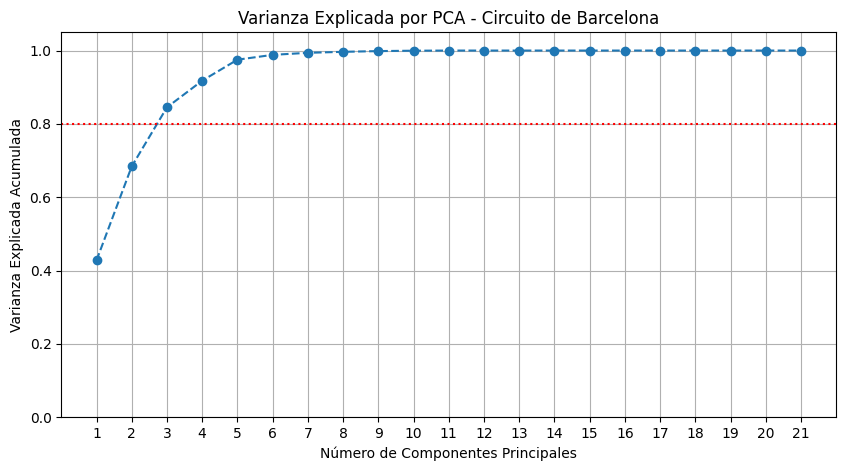

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Ajustar PCA conservando todos los componentes
pca_full = PCA()
pca_full.fit(X_scaled)

# Varianza explicada por componente
explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Gráfico de varianza explicada
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_var) + 1), cumulative_var, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada por PCA - Circuito de Barcelona')
plt.grid(True)
plt.xticks(range(1, len(explained_var) + 1))
plt.ylim(0, 1.05)
plt.axhline(y=0.8, color='r', linestyle=':')  # umbral típico del 80%
plt.show()

Gráfica con los tres componentes.

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # necesario para visualización 3D

# Aplicar PCA con 3 componentes
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

In [7]:
import pandas as pd
import plotly.express as px

# Crear DataFrame con los tres componentes
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3"])

# Añadir tiempo por vuelta como referencia (opcional)
df_pca["lapTime"] = lap_times.values

# Crear gráfico 3D interactivo
fig = px.scatter_3d(df_pca, x="PC1", y="PC2", z="PC3",
                    color="lapTime",  # Escala de color en base al rendimiento
                    color_continuous_scale="Viridis",
                    range_color=[lap_times.min(), lap_times.max()],
                    opacity=0.7,
                    title="PCA 3D - Circuito de Barcelona (color según tiempo por vuelta)",
                    labels={"lapTime": "lapTime (ms)"})

fig.update_layout(scene=dict(
    xaxis_title="Componente 1",
    yaxis_title="Componente 2",
    zaxis_title="Componente 3"
))

fig.show()

Gráfico de barras con la contribución de cada variable para cada uno de los dos componentes.

,PC1,PC2,PC3
m_frontSuspension,0.296784,-0.088865,-0.168849
m_frontLeftTyrePressure,0.290321,0.199052,0.024893
m_frontRightTyrePressure,0.290321,0.199052,0.024893
m_rearLeftTyrePressure,0.280994,0.212232,0.048029
m_rearRightTyrePressure,0.280994,0.212232,0.048029
m_frontWing,0.245821,-0.166115,-0.046599
m_rearAntiRollBar,0.238630,0.023283,0.337685
m_rearWing,0.238567,-0.142993,0.111326
m_engineBraking,0.223773,0.264523,0.136884
m_frontAntiRollBar,0.163318,0.106637,0.338892


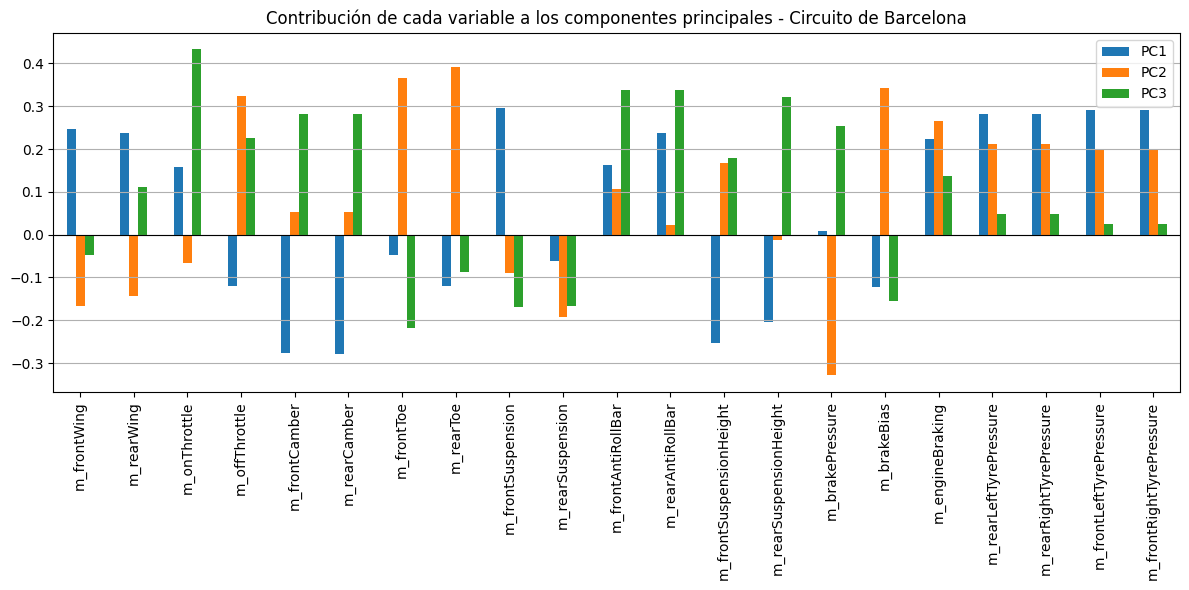

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los nombres de las variables originales
feature_names = X_raw.columns

# Obtener los loadings (coeficientes de cada variable en cada componente)
loadings = pd.DataFrame(pca.components_.T, index=feature_names,
                        columns=['PC1', 'PC2', 'PC3'])

# Mostrar en tabla ordenada por importancia en PC1
display(loadings.sort_values(by='PC1', ascending=False))

# Visualización en gráfico de barras
loadings.plot(kind='bar', figsize=(12, 6))
plt.title("Contribución de cada variable a los componentes principales - Circuito de Barcelona")
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

Top 5 contribuciones positivas/negativas por cada uno de los dos componentes.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Función para mostrar top 5 positivos y negativos de cada componente
def show_top_contributors(loadings, n=5):
    for pc in loadings.columns:
        print(f"\nTop {n} contribuciones positivas en {pc}:")
        print(loadings[pc].sort_values(ascending=False).head(n))

        print(f"\nTop {n} contribuciones negativas en {pc}:")
        print(loadings[pc].sort_values(ascending=True).head(n))

        # Visualización en gráfico de barras
        top_pos = loadings[pc].sort_values(ascending=False).head(n)
        top_neg = loadings[pc].sort_values().head(n)
        top_combined = pd.concat([top_pos, top_neg])

        plt.figure(figsize=(10, 5))
        top_combined.plot(kind='bar',
                          color=['green' if v > 0 else 'red' for v in top_combined])
        plt.title(f'Top {n} contribuciones en {pc} - Circuito de Barcelona')
        plt.axhline(0, color='black', linewidth=0.8)
        plt.ylabel("Peso en el componente")
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()


Top 5 contribuciones positivas en PC1:
m_frontSuspension           0.296784
m_frontLeftTyrePressure     0.290321
m_frontRightTyrePressure    0.290321
m_rearLeftTyrePressure      0.280994
m_rearRightTyrePressure     0.280994
Name: PC1, dtype: float64

Top 5 contribuciones negativas en PC1:
m_rearCamber              -0.278388
m_frontCamber             -0.276257
m_frontSuspensionHeight   -0.253257
m_rearSuspensionHeight    -0.203225
m_brakeBias               -0.122670
Name: PC1, dtype: float64


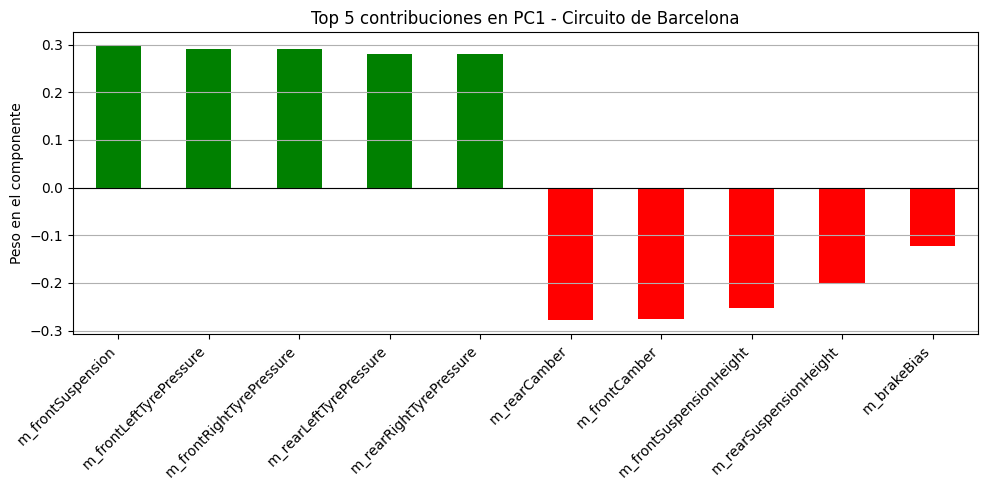


Top 5 contribuciones positivas en PC2:
m_rearToe          0.391771
m_frontToe         0.365729
m_brakeBias        0.342502
m_offThrottle      0.323470
m_engineBraking    0.264523
Name: PC2, dtype: float64

Top 5 contribuciones negativas en PC2:
m_brakePressure     -0.328762
m_rearSuspension    -0.192901
m_frontWing         -0.166115
m_rearWing          -0.142993
m_frontSuspension   -0.088865
Name: PC2, dtype: float64


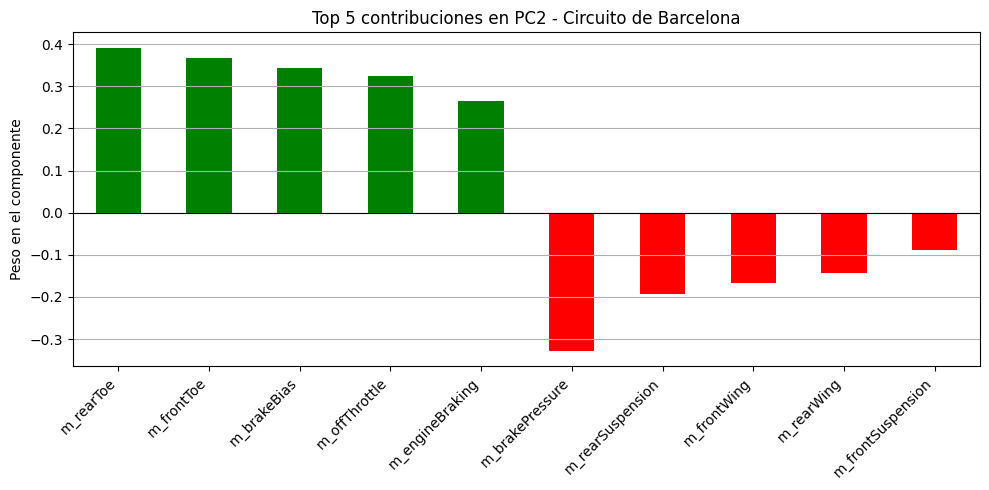


Top 5 contribuciones positivas en PC3:
m_onThrottle              0.433511
m_frontAntiRollBar        0.338892
m_rearAntiRollBar         0.337685
m_rearSuspensionHeight    0.321077
m_frontCamber             0.281780
Name: PC3, dtype: float64

Top 5 contribuciones negativas en PC3:
m_frontToe          -0.217515
m_frontSuspension   -0.168849
m_rearSuspension    -0.166946
m_brakeBias         -0.153956
m_rearToe           -0.086480
Name: PC3, dtype: float64


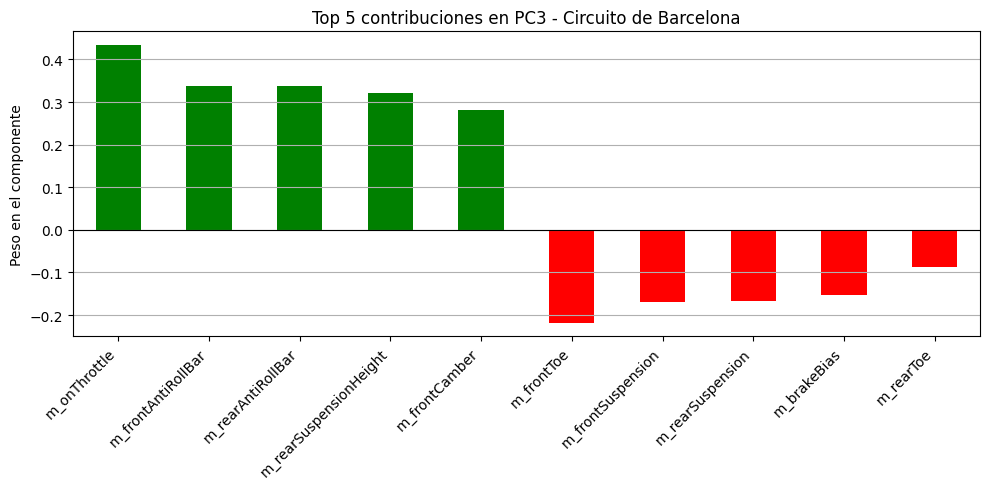

In [10]:
show_top_contributors(loadings, n=5)

Correlación entre cada uno de los componentes y el tiempo por vuelta.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def analyze_pca_vs_lap_time(X_pca, lap_times):
    """
    Analiza la relación entre cada componente principal y el tiempo por vuelta.

    Parámetros:
    - X_pca: array de dimensión (n_samples, n_components) obtenido de PCA.
    - lap_times: array de tiempos por vuelta (n_samples,).

    Salida:
    - Gráficos de dispersión.
    - Correlaciones de Pearson.
    - Coeficientes de determinación R² para cada componente.
    """
    n_components = X_pca.shape[1]

    for i in range(n_components):
        pc = X_pca[:, i]
        corr = np.corrcoef(pc, lap_times)[0, 1]

        # Regresión lineal simple
        reg = LinearRegression().fit(pc.reshape(-1, 1), lap_times)
        r2 = r2_score(lap_times, reg.predict(pc.reshape(-1, 1)))

        # Gráfico
        plt.figure(figsize=(8, 5))
        sns.scatterplot(x=pc, y=lap_times)
        plt.xlabel(f'PC{i+1}')
        plt.ylabel('Tiempo por vuelta')
        plt.title(f'Relación entre PC{i+1} y el tiempo por vuelta - Circuito de Barcelona \nCorrelación = {corr:.3f}, R² = {r2:.3f}')
        plt.grid(True)
        plt.show()

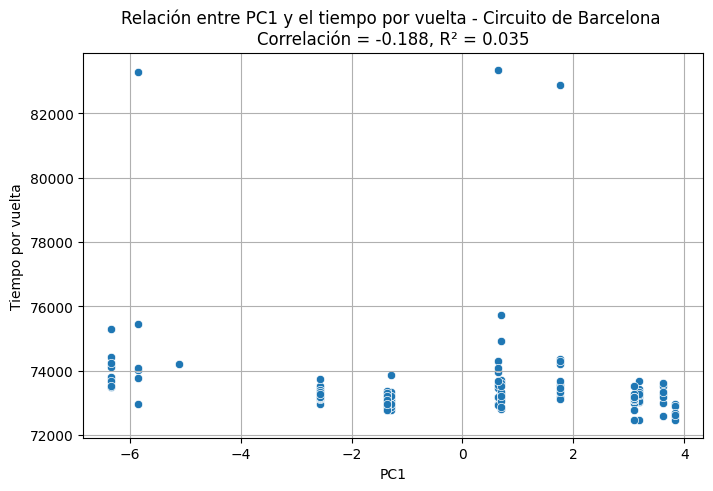

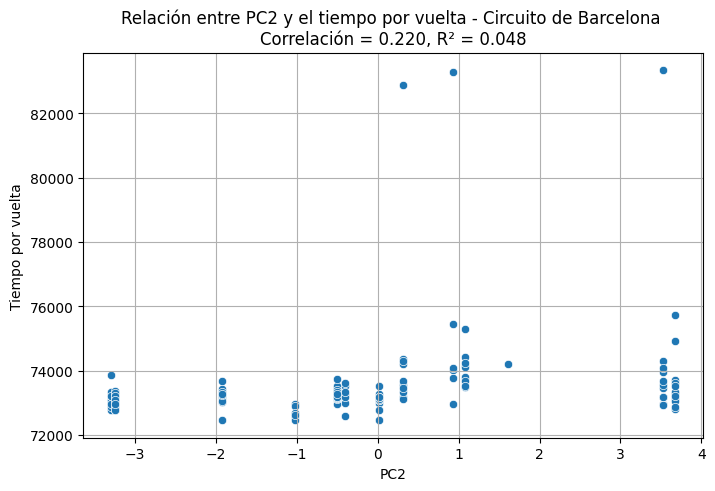

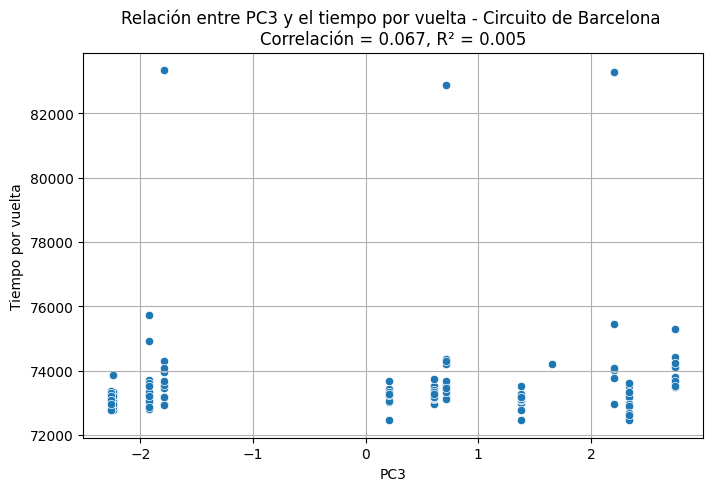

In [12]:
analyze_pca_vs_lap_time(X_pca, lap_times)

## Visualización con t-SNE

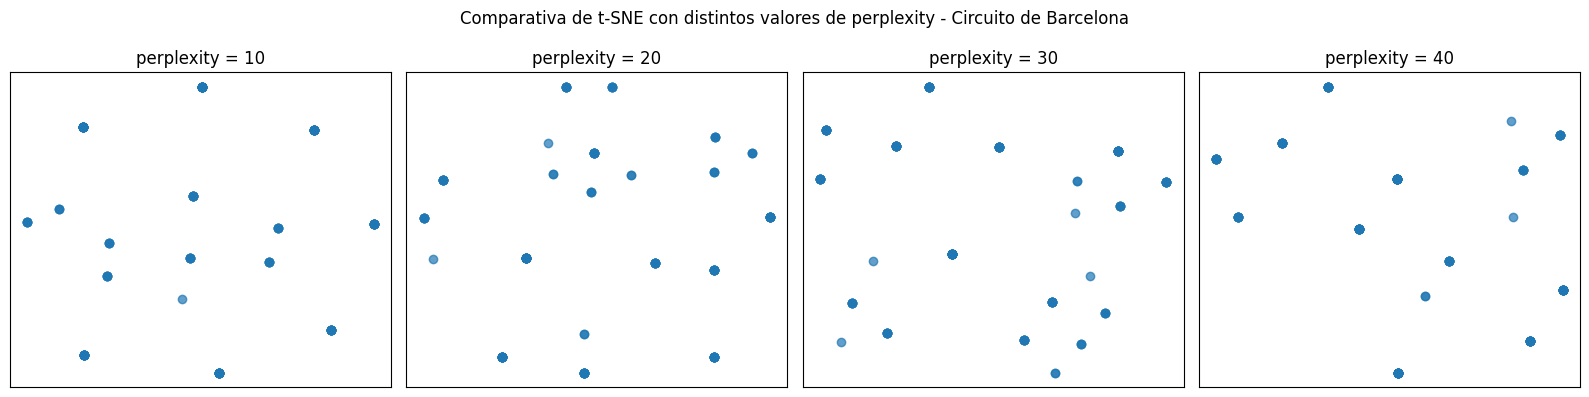

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Valores de perplexity a probar
perplexities = [10, 20, 30, 40]

fig, axs = plt.subplots(1, len(perplexities), figsize=(16, 4))
fig.suptitle("Comparativa de t-SNE con distintos valores de perplexity - Circuito de Barcelona")

for i, perp in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perp, max_iter=600, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)

    axs[i].scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7)
    axs[i].set_title(f"perplexity = {perp}")
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.tight_layout()
plt.show()

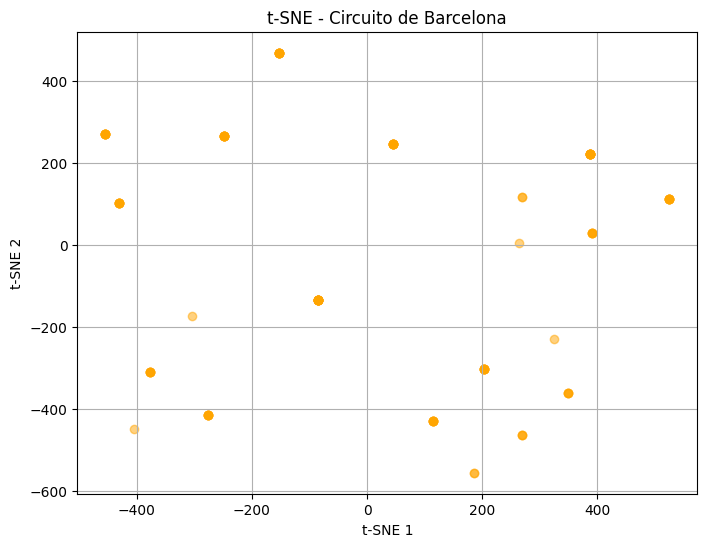

In [14]:
from sklearn.manifold import TSNE

# Aplicar t-SNE
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Visualización t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='orange', alpha=0.5)
plt.title("t-SNE - Circuito de Barcelona")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()

# 🧩 Paso 3: Clustering con K-Means + Silhouette Score

En este paso buscamos identificar agrupaciones naturales (clusters) en los setups del circuito de Barcelona usando K-Means.

Pasos:
1. Calcular el Silhouette Score para valores de K entre 2 y 12 (número de reglajes distintos).
2. Elegir el mejor K.
3. Visualizar los clusters con las proyecciones obtenidas por PCA y t-SNE.

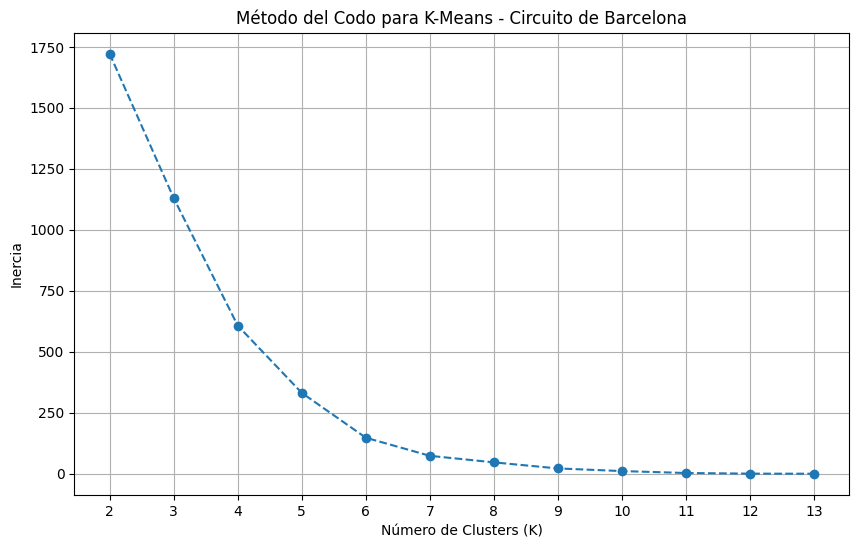

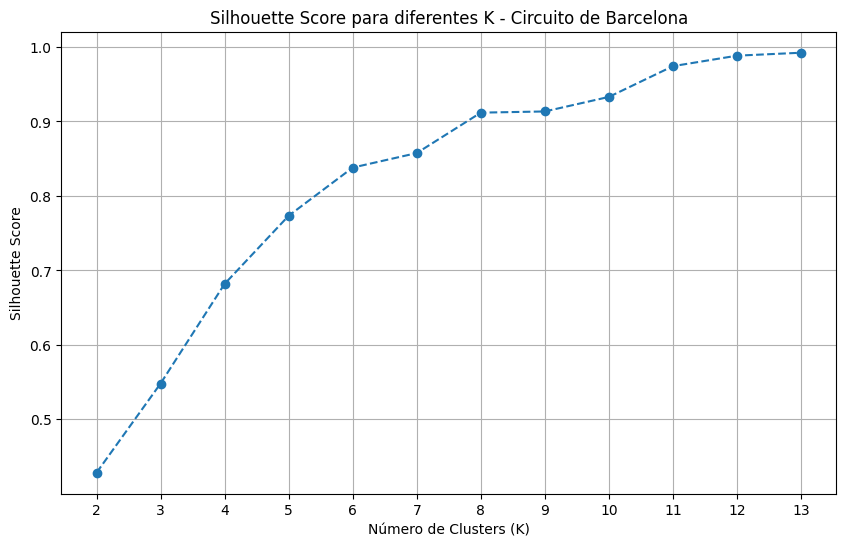

Silhouette Scores: [np.float64(0.42830463332212104), np.float64(0.5480754998931425), np.float64(0.6818576606185024), np.float64(0.7733634138401897), np.float64(0.8380473467835583), np.float64(0.8575482074267615), np.float64(0.9118357797058301), np.float64(0.9134451496028531), np.float64(0.9329698931819143), np.float64(0.9742638123753286), np.float64(0.9883494303129324), np.float64(0.9923076923076923)]
Inertia Scores: [1722.0908220492815, 1130.2150443152225, 607.3005146933716, 331.485621588051, 147.61011096151296, 73.39850308939755, 46.52310733750153, 21.677276986110336, 10.850953196804898, 2.944682301154011, 0.2979371685244359, 7.592893041678841e-29]


In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Rango de K a probar (de 2 a 13 porque tenemos 13 reglajes como máximo)
k_range = range(2, 14)
silhouette_scores = []
inertia_scores = [] # Para el método del codo

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Añadir n_init
    kmeans.fit(X_scaled)

    # Calcular Silhouette Score
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

    # Guardar inercia para el método del codo
    inertia_scores.append(kmeans.inertia_)

# Gráfico del método del codo (Inercia)
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_scores, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-Means - Circuito de Barcelona')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Gráfico de Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para diferentes K - Circuito de Barcelona')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Mostrar los scores para ver numéricamente
print("Silhouette Scores:", silhouette_scores)
print("Inertia Scores:", inertia_scores)

In [16]:
# Elegimos el K donde haya un punto de inflexión
# Entrenamos modelo final
best_k = 6
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
cluster_labels = kmeans_final.fit_predict(X_scaled)

## Visualización con PCA

In [17]:
# Crear DataFrame para visualización
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3"])
df_pca["cluster"] = cluster_labels
df_pca["lapTimeInMS"] = lap_times.values

# Gráfico 3D interactivo
fig = px.scatter_3d(df_pca, x="PC1", y="PC2", z="PC3",
                    color="cluster",  # Colorea por etiqueta de cluster
                    hover_data=["lapTimeInMS"],  # mostrar tiempo en hover
                    title="Clusters con K-Means (PCA 3D) - Circuito de Barcelona")

fig.update_layout(scene=dict(
    xaxis_title="Componente principal 1",
    yaxis_title="Componente principal 2",
    zaxis_title="Componente principal 3"
))

fig.show()

## Visualización con t-SNE

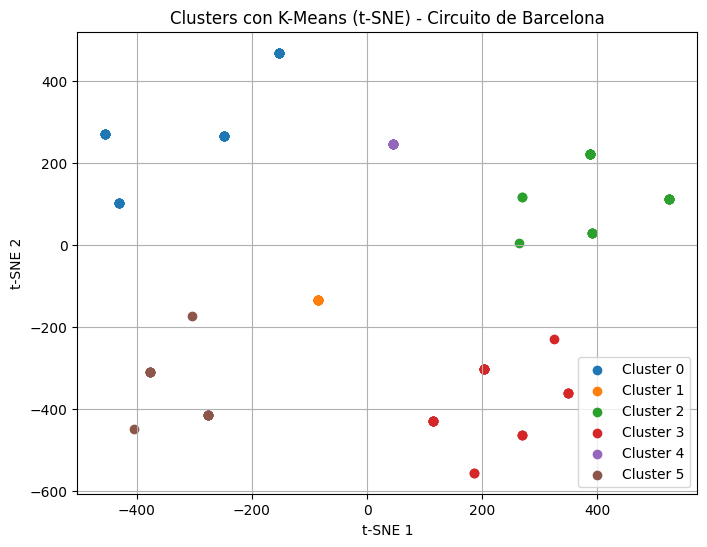

In [18]:
plt.figure(figsize=(8, 6))
for i in range(best_k):
    plt.scatter(X_tsne[cluster_labels == i, 0], X_tsne[cluster_labels == i, 1],
                label=f'Cluster {i}')
plt.title("Clusters con K-Means (t-SNE) - Circuito de Barcelona")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(True)
plt.show()

## Cálculo de centroides con K-Means

In [19]:
import pandas as pd

# Reconstruir los setups escalados a su forma original
X_unscaled = pd.DataFrame(scaler.inverse_transform(X_scaled),
                          columns=X_raw.columns)

# Añadir etiquetas de clúster y tiempo de vuelta original
X_unscaled["cluster"] = cluster_labels
X_unscaled["lapTime"] = lap_times.values

# Agrupar por clúster y calcular centroides (media de setups) y tiempo medio
centroids_df = X_unscaled.groupby("cluster").mean().reset_index()

# Ordenar por tiempo medio de vuelta (opcional, para interpretación posterior)
centroids_df = centroids_df.sort_values(by="lapTime").reset_index(drop=True)

centroids_df.head()

,cluster,m_frontWing,m_rearWing,m_onThrottle,m_offThrottle,m_frontCamber,m_rearCamber,m_frontToe,m_rearToe,m_frontSuspension,...,m_frontSuspensionHeight,m_rearSuspensionHeight,m_brakePressure,m_brakeBias,m_engineBraking,m_rearLeftTyrePressure,m_rearRightTyrePressure,m_frontLeftTyrePressure,m_frontRightTyrePressure,lapTime
0,3,44.520000,30.520000,25.000000,20.000000,-3.5,-2.2,0.000000,0.000000,36.0,...,23.000000,56.0,100.0,51.000000,20.000000,20.9,20.9,23.9,23.9,73089.480000
1,4,39.000000,45.000000,100.000000,20.000000,-3.5,-2.2,0.000000,0.000000,41.0,...,21.000000,54.0,100.0,50.000000,100.000000,26.5,26.5,29.5,29.5,73187.700000
2,1,41.000000,38.000000,45.000000,50.000000,-3.2,-1.9,0.090000,0.080000,30.0,...,25.000000,68.0,97.0,54.000000,30.000000,20.9,20.9,23.9,23.9,73268.533333
3,0,47.567568,37.189189,81.081081,37.837838,-3.5,-2.2,0.000000,0.027027,41.0,...,23.702703,58.0,100.0,51.054054,91.891892,26.5,26.5,29.5,29.5,73439.162162
4,2,39.142857,30.000000,30.000000,45.000000,-3.5,-2.2,0.228571,0.250000,35.0,...,25.000000,55.0,95.0,55.000000,100.000000,26.5,26.5,29.5,29.5,73847.821429


## Exportado de centroides con K-Means

In [20]:
# Exportamos los centroides para usarlos en el sistema recomendador
centroids_df.to_csv("barcelona_kmeans_centroids.csv", index=False)
print("Centroides exportados correctamente a 'barcelona_kmeans_centroids.csv'")

Centroides exportados correctamente a 'barcelona_kmeans_centroids.csv'


# ⚙️ Paso 4: Clustering con DBSCAN

Utilizaremos el algoritmo DBSCAN para encontrar agrupaciones sin necesidad de definir el número de clusters.

Pasos:
1. Ajustar el modelo DBSCAN sobre los datos normalizados.
2. Visualizar los clusters con PCA y t-SNE.
3. Calcular los centroides descartando el ruido (`cluster = -1`).
4. Exportar los centroides para el sistema recomendador.

Gráfico de distancias al k-ésimo vecino más cercano (k-distance plot)

In [21]:
print(X_scaled.shape)
print(np.unique(X_scaled, axis=0).shape)

(130, 21)
(13, 21)


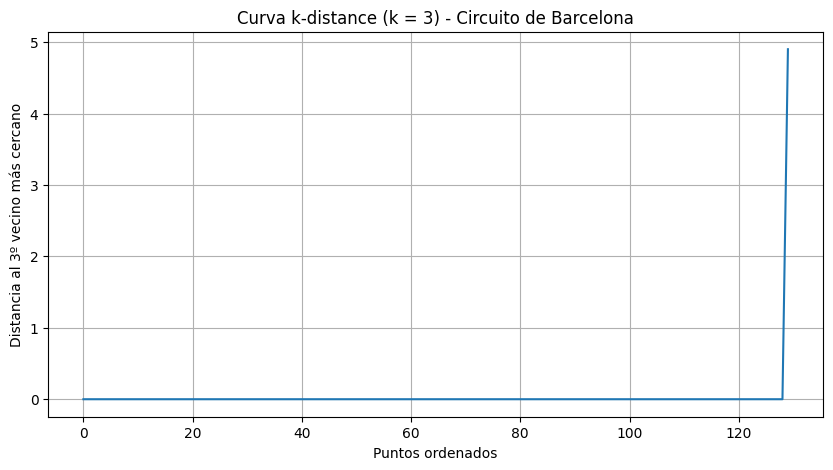

In [22]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Número mínimo de muestras que queremos considerar para DBSCAN
min_samples = 3  # entre 3 o 5

# Calcular distancias al k-ésimo vecino más cercano
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)  # o X_pca si usas la proyección
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Extraer la distancia al k-ésimo vecino más cercano (última columna)
k_distances = np.sort(distances[:, -1])

# Gráfico
plt.figure(figsize=(10, 5))
plt.plot(k_distances)
plt.title(f'Curva k-distance (k = {min_samples}) - Circuito de Barcelona')
plt.xlabel('Puntos ordenados')
plt.ylabel(f'Distancia al {min_samples}º vecino más cercano')
plt.grid(True)
plt.show()


In [23]:
print(k_distances[:10])  # ver primeras distancias
print(k_distances[-10:]) # ver últimas

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[8.42936970e-08 8.42936970e-08 8.42936970e-08 1.19209290e-07
 1.19209290e-07 1.19209290e-07 1.19209290e-07 1.19209290e-07
 1.19209290e-07 4.90052635e+00]


Agrupar reglajes únicos y persistir el tiempo más rápido.

In [24]:
# Unir X_raw y lap_times en un único DataFrame
df_full = X_raw.copy()
df_full["lapTime"] = lap_times.values

# Agrupar por combinaciones únicas de reglajes y calcular la media de tiempos
df_grouped = df_full.groupby(list(X_raw.columns)).agg({
    "lapTime": "min"
}).reset_index()

Estandarizar reglajes únicos.

In [25]:
from sklearn.preprocessing import StandardScaler

X_unique = df_grouped.drop(columns=["lapTime"])
y_unique = df_grouped["lapTime"]

scaler = StandardScaler()
X_scaled_unique = scaler.fit_transform(X_unique)

Determinar eps con curva k-distance.

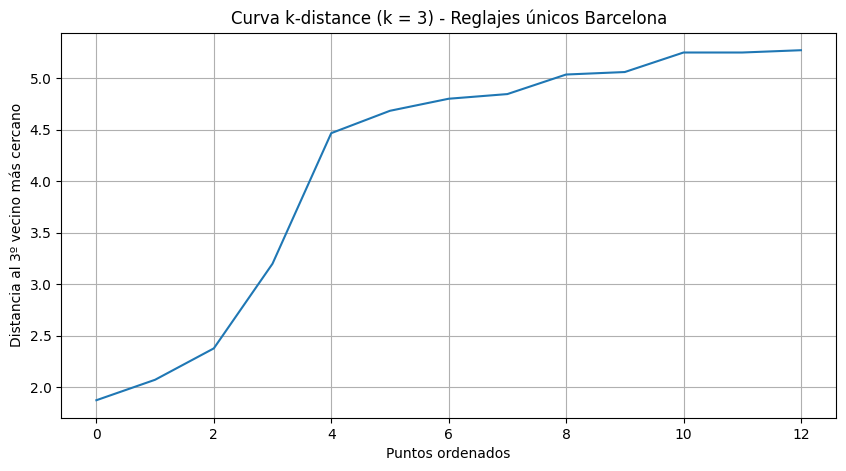

In [26]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

min_samples = 3  # ajustar de 3 a 5
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled_unique)
distances, indices = neighbors_fit.kneighbors(X_scaled_unique)
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(10, 5))
plt.plot(k_distances)
plt.title(f'Curva k-distance (k = {min_samples}) - Reglajes únicos Barcelona')
plt.xlabel('Puntos ordenados')
plt.ylabel(f'Distancia al {min_samples}º vecino más cercano')
plt.grid(True)
plt.show()


Aplicar DBSCAN sobre los datos únicos.

In [27]:
from sklearn.cluster import DBSCAN

# Estimar eps visualmente desde la curva anterior
eps = 4.5  # lo ajustamos en función de la gráfica
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
db_labels = dbscan.fit_predict(X_scaled_unique)

# Añadir los resultados al DataFrame agrupado
df_grouped["cluster"] = db_labels

# Contar etiquetas encontradas
n_clusters_db = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise = list(db_labels).count(-1)
print(f"🔍 DBSCAN encontró {n_clusters_db} clusters y {n_noise} puntos de ruido.")

🔍 DBSCAN encontró 2 clusters y 5 puntos de ruido.


## Visualización con PCA

In [28]:
from sklearn.decomposition import PCA
import plotly.express as px

X_pca_dbscan = pca.fit_transform(X_scaled_unique)

df_grouped[["PC1", "PC2", "PC3"]] = X_pca_dbscan

fig = px.scatter_3d(df_grouped, x="PC1", y="PC2", z="PC3",
                    color="cluster",
                    hover_data=["lapTime"],
                    title="Clusters DBSCAN (PCA 3D) - Circuito de Barcelona")
fig.show()

## Visualización con t-SNE

In [29]:
tsne = TSNE(n_components=2, perplexity=2, max_iter=1000, random_state=42)
X_tsne_dbscan = tsne.fit_transform(X_scaled_unique)

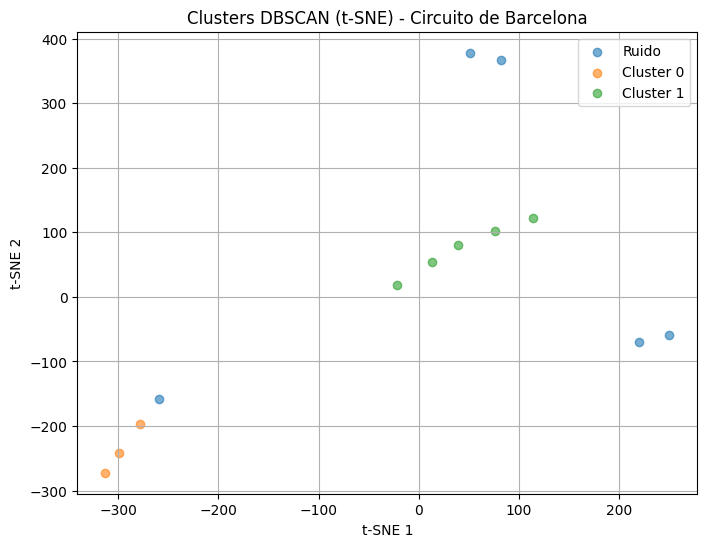

In [30]:
plt.figure(figsize=(8, 6))
unique_labels = np.unique(db_labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    class_member_mask = (db_labels == k)
    label = "Ruido" if k == -1 else f"Cluster {k}"
    plt.scatter(X_tsne_dbscan[class_member_mask, 0], X_tsne_dbscan[class_member_mask, 1],
                label=label, alpha=0.6)

plt.title("Clusters DBSCAN (t-SNE) - Circuito de Barcelona")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(True)
plt.show()

## Cálculo de centroides (sin ruido)

In [31]:
# Reconstrucción de los reglajes originales desde los datos únicos
X_db_unscaled = pd.DataFrame(scaler.inverse_transform(X_scaled_unique),
                             columns=X_raw.columns)  # usar las columnas originales de reglajes

# Añadir etiquetas de cluster y tiempos mínimos
X_db_unscaled["cluster"] = db_labels  # obtenidos de DBSCAN
X_db_unscaled["lapTime"] = y_unique.values  # mejores tiempos por reglaje

# Filtrar los puntos que no son ruido
X_db_filtered = X_db_unscaled[X_db_unscaled["cluster"] != -1]

# Calcular centroides de cada cluster y tiempo medio por vuelta
db_centroids_df = X_db_filtered.groupby("cluster").mean().reset_index()

# Ordenar por tiempo medio (el más bajo primero)
db_centroids_df = db_centroids_df.sort_values(by="lapTime").reset_index(drop=True)

# Mostrar primeros centroides
db_centroids_df.head()

,cluster,m_frontWing,m_rearWing,m_onThrottle,m_offThrottle,m_frontCamber,m_rearCamber,m_frontToe,m_rearToe,m_frontSuspension,...,m_frontSuspensionHeight,m_rearSuspensionHeight,m_brakePressure,m_brakeBias,m_engineBraking,m_rearLeftTyrePressure,m_rearRightTyrePressure,m_frontLeftTyrePressure,m_frontRightTyrePressure,lapTime
0,1,46.000000,39.000000,86.0,34.000000,-3.500000,-2.2,0.000000,0.02,41.0,...,23.000000,57.4,100.0,50.8,94.000000,26.5,26.5,29.500000,29.500000,72616.800000
1,0,25.333333,24.666667,60.0,48.333333,-2.866667,-1.6,0.113333,0.21,13.0,...,33.666667,69.0,100.0,54.0,53.333333,21.0,21.0,23.466667,23.466667,73555.333333


## Exportado de centroides con DBSCAN

In [32]:
# Exportar a CSV para uso en recomendador
db_centroids_df.to_csv("barcelona_dbscan_centroids.csv", index=False)
print("Centroides DBSCAN exportados correctamente a 'barcelona_dbscan_centroids.csv'")

Centroides DBSCAN exportados correctamente a 'barcelona_dbscan_centroids.csv'


# 🧐 Paso 5: Intrepretación de Clusters
Después de visualizar los distintos cluster usando algoritmos de clustering (K-means y DBSCAN), vamos a identificar cuál es el cluster donde el tiempo por vuelta es más rápido. Para ello, tomaremos los tiempos por vuelta de cada cluster y haremos la media de ellos, viendo así cuál es el tiempo por vuelta medio más bajo (la recomendación).

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_cluster_performance(cluster_labels, lap_times, X_original, feature_names=None):
    """
    Evalúa el rendimiento por cluster con tiempos de vuelta y devuelve el reglaje medio del mejor cluster.

    Parámetros:
    - cluster_labels: array (n_samples,) con etiquetas de clustering (KMeans, DBSCAN, etc.).
    - lap_times: array (n_samples,) con los tiempos por vuelta.
    - X_original: array o DataFrame con los reglajes sin escalar (shape: n_samples, n_features).
    - feature_names: lista opcional con nombres de las columnas de X_original.

    Retorna:
    - best_cluster: etiqueta del cluster con mejor tiempo medio.
    - average_setup: Series con el reglaje promedio de ese cluster.
    """

    # Crear DataFrame con resultados
    df = pd.DataFrame({
        'cluster': cluster_labels,
        'lap_time': lap_times
    })

    # Agrupación por cluster
    summary = df.groupby('cluster')['lap_time'].agg(['mean', 'std', 'count']).sort_values('mean')

    print("📊 Resumen por cluster (ordenado por mejor tiempo medio):")
    display(summary)

    # Visualización
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='cluster', y='lap_time', data=df)
    plt.title("Distribución del tiempo por vuelta por cluster - Circuito de Barcelona")
    plt.xlabel("Cluster")
    plt.ylabel("Tiempo por vuelta")
    plt.grid(True)
    plt.show()

    # Identificar el mejor cluster
    best_cluster = summary.index[0]
    print(f"🏁 El cluster más rápido en Barcelona es el #{best_cluster} con tiempo medio de {summary.loc[best_cluster, 'mean']:.3f} s")

    # Cálculo del reglaje promedio de ese cluster
    if isinstance(X_original, pd.DataFrame):
        best_setups = X_original[cluster_labels == best_cluster]
    else:
        best_setups = pd.DataFrame(X_original[cluster_labels == best_cluster],
                                   columns=feature_names)

    average_setup = best_setups.mean()

    print("\n🔧 Reglaje promedio del mejor cluster:")
    display(average_setup)

    return best_cluster, average_setup

## K-Means

📊 Resumen por cluster (ordenado por mejor tiempo medio):


,mean,std,count
cluster,,,
3,73089.480000,239.331381,25
4,73187.700000,317.841348,10
1,73268.533333,195.793574,15
0,73439.162162,1661.157169,37
2,73847.821429,1966.146957,28
5,74692.066667,2467.131054,15


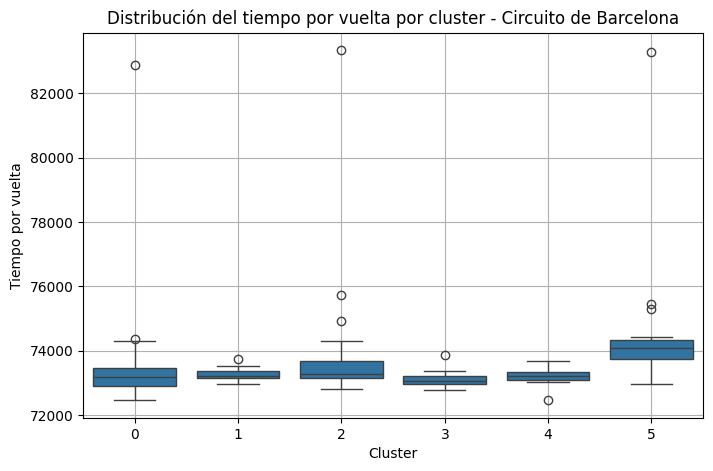

🏁 El cluster más rápido en Barcelona es el #3 con tiempo medio de 73089.480 s

🔧 Reglaje promedio del mejor cluster:


,0
m_frontWing,44.52
m_rearWing,30.52
m_onThrottle,25.00
m_offThrottle,20.00
m_frontCamber,-3.50
m_rearCamber,-2.20
m_frontToe,0.00
m_rearToe,0.00
m_frontSuspension,36.00
m_rearSuspension,11.00


In [34]:
best_cluster, best_setup = analyze_cluster_performance(
    cluster_labels=cluster_labels,
    lap_times=lap_times,
    X_original=X_raw,  # sin escalar
    feature_names=X_raw.columns.tolist()
)

## DBSCAN

📊 Resumen por cluster (ordenado por mejor tiempo medio):


,mean,std,count
cluster,,,
1,72616.800000,285.088933,5
-1,72846.400000,93.023115,5
0,73555.333333,631.539653,3


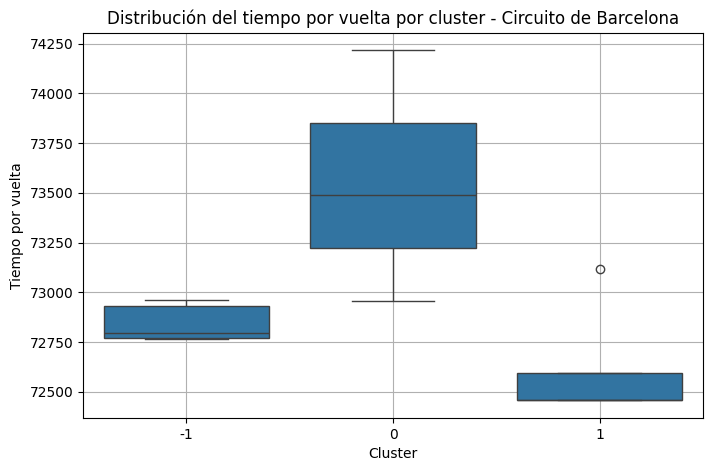

🏁 El cluster más rápido en Barcelona es el #1 con tiempo medio de 72616.800 s

🔧 Reglaje promedio del mejor cluster:


,0
m_frontWing,46.00
m_rearWing,39.00
m_onThrottle,86.00
m_offThrottle,34.00
m_frontCamber,-3.50
m_rearCamber,-2.20
m_frontToe,0.00
m_rearToe,0.02
m_frontSuspension,41.00
m_rearSuspension,5.60


In [35]:
best_cluster, best_setup = analyze_cluster_performance(
    cluster_labels=db_labels,
    lap_times=y_unique,
    X_original=X_unique,
    feature_names=X_unique.columns.tolist()
)

## Clusters Lentos Vs Rápidos
Finalmente, miraremos aquellos clusters cuyos centroides tienen un tiempo por vuelta superior o inferior a la media de todos los tiempos.

In [36]:
from scipy.stats import mode
import matplotlib.pyplot as plt
import numpy as np

def plot_fast_vs_slow_clusters(centroids_df, lap_times, title_suffix="K-Means", reference="mean"):
    """
    Dibuja un gráfico de barras para comparar tiempos medios de clusters contra la media o moda global.

    Parámetros:
    - centroids_df: DataFrame con columna 'cluster' y 'lapTime'
    - lap_times: Serie o array con todos los tiempos por vuelta
    - title_suffix: "K-Means" o "DBSCAN"
    - reference: 'mean' o 'mode' (define con qué se comparan los centroides)
    """
    # Selección de umbral de comparación
    if reference == "mean":
      ref_value = lap_times.mean()
      ref_label = f"Media global: {ref_value:.0f} ms"
    elif reference == "median":
      ref_value = np.median(lap_times)
      ref_label = f"Mediana global: {ref_value:.0f} ms"
    elif reference == "mode":
      ref_result = mode(lap_times, keepdims=True)  # <-- importante porque sino se devuelve un escalar en vez de un array
      ref_value = ref_result.mode[0]
      ref_label = f"Moda global: {ref_value:.0f} ms"
    else:
        raise ValueError("Parámetro 'reference' debe ser 'mean' o 'mode'.")

    # Gráfico
    plt.figure(figsize=(8, 6))
    plt.bar(centroids_df["cluster"], centroids_df["lapTime"], color='skyblue', edgecolor='black')

    # Línea horizontal de referencia
    plt.axhline(ref_value, color='red', linestyle='--', label=ref_label)

    # Anotaciones: "Rápido"/"Lento" con respecto al umbral
    for idx, row in centroids_df.iterrows():
        label = "Rápido" if row["lapTime"] < ref_value else "Lento"
        plt.text(row["cluster"], row["lapTime"] + 100, label, ha='center', fontsize=9)

    # Ajuste eje Y
    min_lap = centroids_df["lapTime"].min()
    max_lap = centroids_df["lapTime"].max()
    delta = max_lap - min_lap
    margin = delta * 0.25
    plt.ylim(min_lap - margin, max_lap + margin)

    # Título y estilo
    plt.title(f"Comparación de Clusters: Rápidos vs Lentos ({title_suffix}, ref: {reference}) - Circuito de Barcelona")
    plt.xlabel("Cluster")
    plt.ylabel("Tiempo medio por vuelta (ms)")
    plt.legend()
    plt.grid(True)
    plt.show()

## K-Means

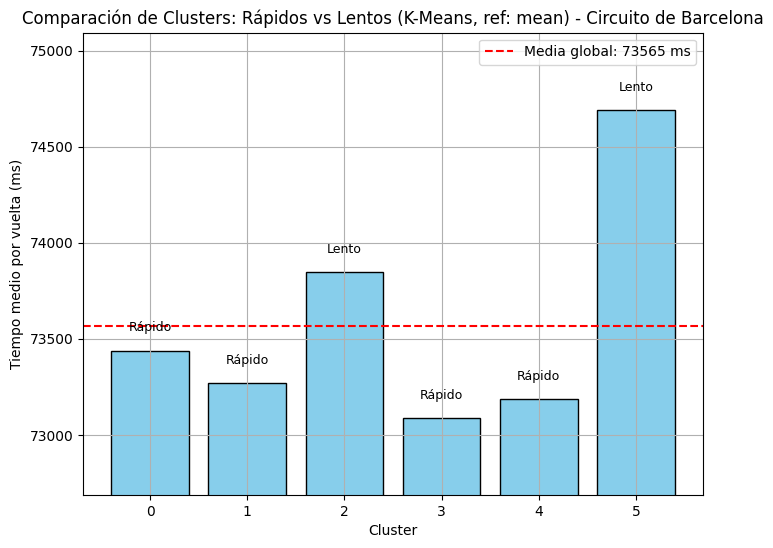

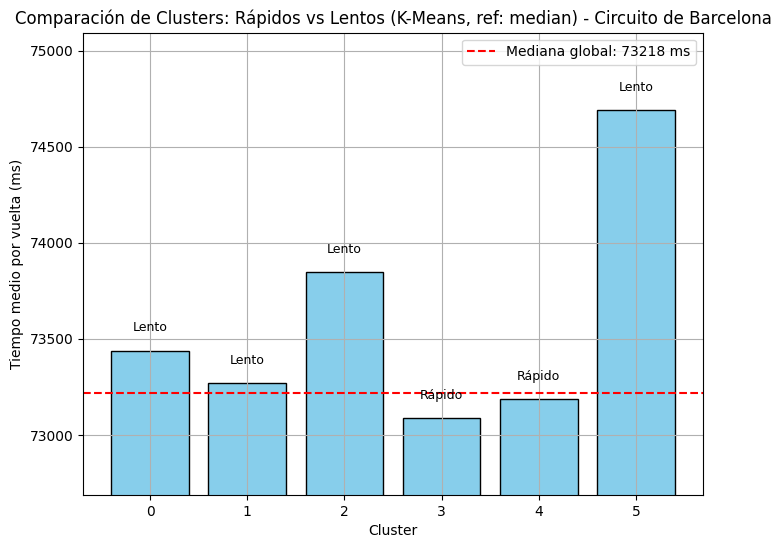

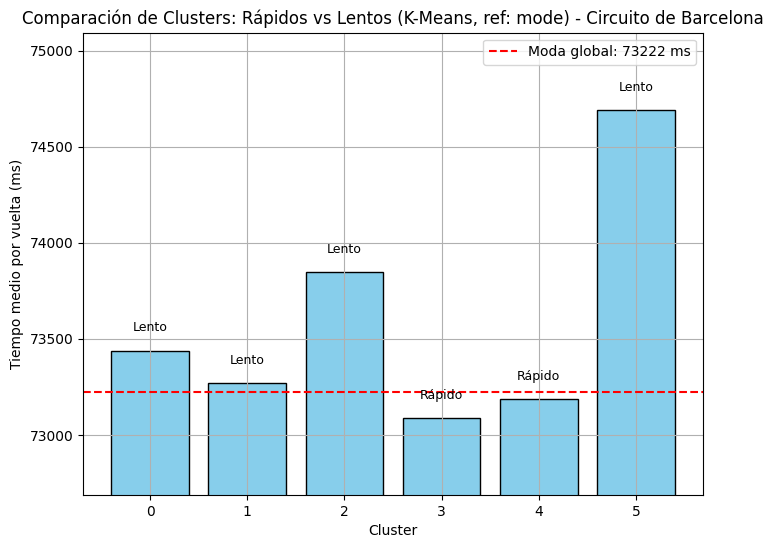

In [37]:
plot_fast_vs_slow_clusters(centroids_df, lap_times, title_suffix="K-Means", reference="mean")
plot_fast_vs_slow_clusters(centroids_df, lap_times, title_suffix="K-Means", reference="median")
plot_fast_vs_slow_clusters(centroids_df, lap_times, title_suffix="K-Means", reference="mode")

## DBSCAN

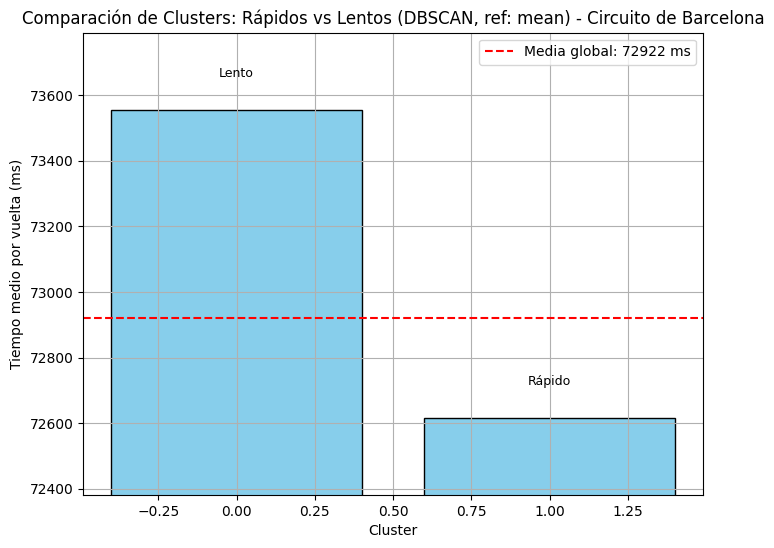

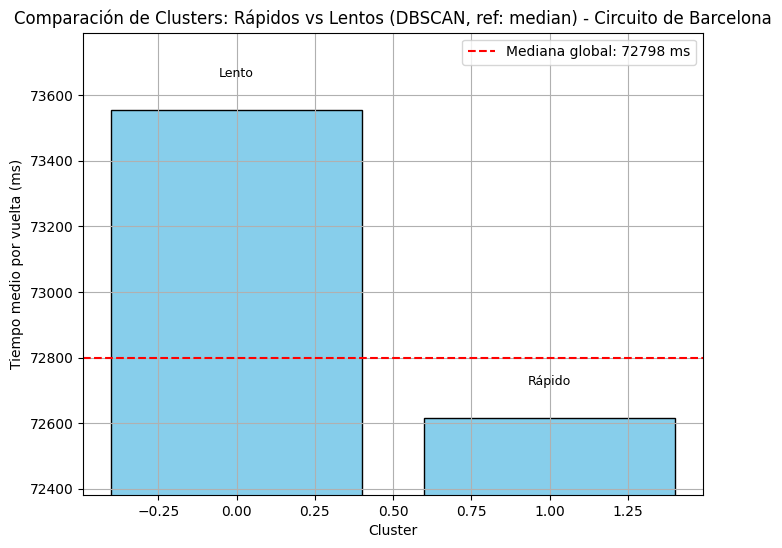

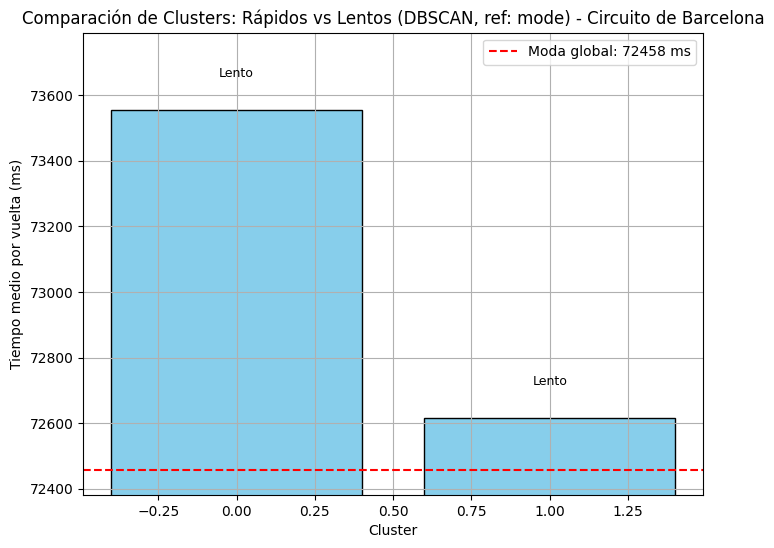

In [38]:

plot_fast_vs_slow_clusters(db_centroids_df, y_unique, title_suffix="DBSCAN", reference="mean")
plot_fast_vs_slow_clusters(db_centroids_df, y_unique, title_suffix="DBSCAN", reference="median")
plot_fast_vs_slow_clusters(db_centroids_df, y_unique, title_suffix="DBSCAN", reference="mode")
